# Setup

In [ ]:
try:
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  path_top = '/content/drive/MyDrive/Master Thesis/'
  !cp /content/drive/MyDrive/Master\ Thesis/repo/code/dataset.zip .
  !unzip -q dataset.zip 
except Exception:
  path_top = ''

Mounted at /content/drive


In [ ]:
!pip install ltn -qqq
!pip install tensorflow-io -qqq
!pip install tensorflow-addons -qqq
!cp /content/drive/MyDrive/Master\ Thesis/repo/code/params.py .
!cp /content/drive/MyDrive/Master\ Thesis/repo/code/melspec.py .

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.2 MB/s eta 0:00:00


In [ ]:
import ltn
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_io as tfio
import tensorflow_addons as tfaddons
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow_datasets as tfds
from IPython.display import Audio, display
from tensorflow.keras import layers
from scipy.io import wavfile as wf

import params
from melspec import MelSpec

In [ ]:
VAL_SPLIT = 0.9
audio_path  = 'dataset/audio' #path_top + 'notebooks/dataset/audio'

LABEL_RATE  = 2
label_path  = 'dataset/DEAM_Annotations/annotations/annotations averaged per song/dynamic (per second annotations)'

# this variable is probably stupid
EMOTION = {'happy':0, 'tense':1, 'sombre':2, 'relaxed':3, 0:'happy', 1:'tense', 2:'sombre', 3:'relaxed'}

---
# Dataset

## Load Audio Data

In [ ]:
def load_audio_data():
    ds_audio_train = tf.keras.utils.audio_dataset_from_directory(
        audio_path,
        labels=None,
        batch_size=None,
        shuffle=False,
        seed=None,
        #validation_split=VAL_SPLIT,
        #subset='training',
        output_sequence_length=(45 * params.SAMPLE_RATE), # 45 seconds
        follow_links=True
    )

    ds_audio_val = tf.keras.utils.audio_dataset_from_directory(
        audio_path,
        labels=None,
        batch_size=None,
        shuffle=False,
        seed=None,
        #validation_split=VAL_SPLIT,
        #subset='validation',
        output_sequence_length=(45 * params.SAMPLE_RATE), # 45 seconds
        follow_links=True
    )
    return ds_audio_train, ds_audio_val

## Audio Preprocessing

### Skip first 15 seconds
The first 15 seconds have not been annotated. They could still be useful to the model since they could affect the emotion of the annotated samples, but for now they are not included. 

In [ ]:
_15_SEC_SKIP = 15* params.SAMPLE_RATE

def skip15sec(data):
    return data[_15_SEC_SKIP:]

### Make mono

In [ ]:
def to_mono(data):
    return data[...,0] # take first channel

### Reshape data to match labels

In [ ]:
def reshape_data(data):
    if (len(data) == 0):
        return data
    #n_channels = 2
    return tf.reshape(data, (LABEL_RATE * 30,params.SAMPLE_RATE//LABEL_RATE, ))#n_channels))

In [ ]:
def sequence_spect(data, seq_len=params.SEQ_LENGTH, lstm_window=params.LSTM_WINDOW, bins=params.MEL_BINS):
    if len(data) == 0:
        return data
    trim = len(data) - seq_len * lstm_window
    i = np.random.randint(trim+1)
    trim = trim - i
    data = data[i:-trim if trim else None]
    if (len(data) != 5120):
        raise Exception("Uh oh")

#    data = data[:seq_len * lstm_window]

    return tf.reshape(data, (seq_len, lstm_window, bins))

### Mel-scaled Fourier transform

In [ ]:
mel_spec = MelSpec(
    frame_length = params.STFT_WINDOW,
    frame_step = params.STFT_HOP,
    sampling_rate = params.SAMPLE_RATE,
    num_mel_channels = params.MEL_BINS,
    freq_min = params.MEL_FREQ_MIN,
    freq_max = params.MEL_FREQ_MAX,
    min_db = -params.DB_MIN,
)

def mel_spectrogram(data):
    S = mel_spec(tf.expand_dims(data, -1))
    return S

# uses griffin-lim if no model i supplied
def mel_to_audio(S, model=None):
    if model is not None:
        return model(tf.expand_dims(S, 0), training=False)
    
    S = tf.cast(S, tf.float32)

    # mel to linear
    mel_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=params.MEL_BINS,
        num_spectrogram_bins=params.STFT_WINDOW//2+1,
        sample_rate=params.SAMPLE_RATE,
        lower_edge_hertz=params.MEL_FREQ_MIN,
        upper_edge_hertz=params.MEL_FREQ_MAX,
        dtype=tf.dtypes.float32
    )
    with np.errstate(divide="ignore", invalid="ignore"):
        mel_inversion_matrix = tf.constant(
            np.nan_to_num(
                np.divide(mel_matrix.numpy().T, np.sum(mel_matrix.numpy(), axis=1))
            ).T
        )
    S = tf.tensordot(S, tf.transpose(mel_inversion_matrix), 1)
    
    
    # dB to amplitude
    S = tf.pow(tf.ones(tf.shape(S)) * 10.0, (S) / 20)  # 10^(dB / 20)
    
    # Griffin-Lim:
    return tfio.audio.inverse_spectrogram(S, params.STFT_WINDOW, params.STFT_WINDOW, params.STFT_HOP, iterations=params.GRIFFIN_LIM_ITER)

### Map preprocessing to dataset

In [ ]:
ds_audio_train, _ = load_audio_data()

ds_audio_train = ds_audio_train.map(skip15sec)
ds_audio_train = ds_audio_train.map(to_mono)
ds_spect_train = ds_audio_train.map(mel_spectrogram)
ds_spect_train = ds_spect_train.map(sequence_spect)
ds_spect_train = ds_spect_train.batch(params.BATCH_SIZE)

#ds_audio_val = ds_audio_val.map(skip15sec)
#ds_audio_val = ds_audio_val.map(to_mono)
#ds_spect_val = ds_audio_val.map(mel_spectrogram)
#ds_spect_val = ds_spect_val.map(sequence_spect)
#ds_spect_val = ds_spect_val.batch(params.BATCH_SIZE)

Found 1802 files belonging to 1 classes.
Found 1802 files belonging to 1 classes.


### Check audio data

In [ ]:
## S := TxF matrix
def show_spectrogram(S, title='', n_spect=1, scale=5):
    #fig, ax = plt.subplots(ncols=1, figsize=(15,4))
    #cax = ax.matshow(S.T, aspect='auto', origin='lower')
    #fig.colorbar(cax)
    plt.figure(figsize=(scale*n_spect, scale))
    plt.imshow(S.T, origin='lower', vmin=-40, vmax=70)
    plt.axis('off')
    plt.title(title)
    plt.show()
    plt.close()

def show_audio(S):
    rec_aud = mel_to_audio(S)
    wf.write('rec.wav', params.SAMPLE_RATE, rec_aud.numpy())
    rec = Audio('rec.wav')
    display(rec)

-36.813786 53.531345


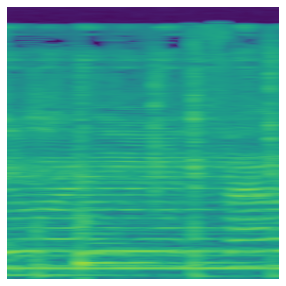

In [ ]:
# FOR SPECTROGRAMS
skip = 0
n_bat = 1
n = 1
for X in ds_spect_train.skip(skip).take(n_bat):
    for x in X[0].numpy()[:n]:
        print(np.min(x), np.max(x))
        show_spectrogram(x)
        show_audio(x)

_="""
# AUDIO for reference
aud = None
for a in ds_audio_train.skip(skip).take(n):
    if aud is None:
       aud = a.numpy()
    else:    
        aud = np.concatenate((aud, a), axis=0)

wf.write('test.wav', params.SAMPLE_RATE, aud)
test = Audio('test.wav')
display(test)
"""

Audio file for comparison (beginning at 15 seconds)

In [ ]:
#Audio(f'{audio_path}/0002.wav', rate=44100)

## Load Labels

In [ ]:
ds_valence = pd.read_csv(f"{label_path}/valence.csv")
ds_valence = ds_valence.dropna(axis=1)
ds_valence = ds_valence.drop(columns='song_id')
ds_valence

,sample_15000ms,sample_15500ms,sample_16000ms,sample_16500ms,sample_17000ms,sample_17500ms,sample_18000ms,sample_18500ms,sample_19000ms,sample_19500ms,...,sample_40000ms,sample_40500ms,sample_41000ms,sample_41500ms,sample_42000ms,sample_42500ms,sample_43000ms,sample_43500ms,sample_44000ms,sample_44500ms
0,-0.073341,-0.074661,-0.074077,-0.078154,-0.081588,-0.080873,-0.083611,-0.082145,-0.081632,-0.083874,...,-0.317376,-0.324846,-0.324680,-0.328112,-0.330134,-0.330134,-0.331164,-0.331769,-0.334287,-0.333846
1,-0.189702,-0.187765,-0.183740,-0.188761,-0.193704,-0.190834,-0.189041,-0.197554,-0.202871,-0.209757,...,-0.302453,-0.313982,-0.305432,-0.294850,-0.282940,-0.276367,-0.279427,-0.278662,-0.274248,-0.270162
2,0.154286,0.148063,0.146956,0.151180,0.135942,0.076832,0.084487,0.088513,0.090944,0.085544,...,0.217544,0.217568,0.218895,0.222275,0.190338,0.173086,0.174892,0.179884,0.182710,0.179332
3,0.149053,0.148260,0.147369,0.146956,0.147857,0.146927,0.145651,0.145795,0.146420,0.152565,...,0.132608,0.133477,0.133477,0.134290,0.133555,0.134592,0.134347,0.133955,0.133477,0.133477
4,0.342816,0.345193,0.332023,0.328887,0.327603,0.329011,0.327883,0.334822,0.328447,0.344121,...,0.349402,0.327612,0.330913,0.331320,0.301550,0.295276,0.295031,0.319244,0.316518,0.321731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1797,0.088000,0.088000,0.086000,0.080000,0.070000,0.068000,0.076000,0.078000,0.074000,0.074000,...,0.120000,0.118000,0.116000,0.118000,0.120000,0.122000,0.120000,0.120000,0.120000,0.116000
1798,0.128000,0.098000,0.080000,0.080000,0.088000,0.088000,0.086000,0.078000,0.068000,0.066000,...,0.026000,0.038000,0.038000,0.034000,0.010000,0.016000,0.018000,0.018000,0.016000,0.016000
1799,0.198000,0.182000,0.164000,0.156000,0.148000,0.142000,0.144000,0.146000,0.160000,0.168000,...,0.154000,0.156000,0.152000,0.144000,0.146000,0.156000,0.162000,0.152000,0.138000,0.136000
1800,-0.071667,-0.061667,-0.076667,-0.078333,-0.081667,-0.046667,-0.046667,-0.068333,-0.113333,-0.133333,...,-0.215000,-0.191667,-0.190000,-0.188333,-0.188333,-0.191667,-0.191667,-0.191667,-0.191667,-0.193333


In [ ]:
ds_arousal = pd.read_csv(f"{label_path}/arousal.csv")
ds_arousal = ds_arousal.dropna(axis=1)
ds_arousal = ds_arousal.drop(columns='song_id')
#ds_arousal

In [ ]:
np.array([ds_arousal.values[i] for i in range(ds_arousal.shape[0])]).shape

(1802, 60)

### Binning
To be able to write predicates that evaluate to True|False, the data needs to be categorical. Ideally, the data would have attributes like chord, tempo, dynamics etc. that would make this a bit more interesting and informative.


In this project the predicates will simply divide the valence and arousal regression into smaller classification tasks. For instance, instead of predicting `valence(x) = 0.7` we may have a predicate `high_valence(x) = True`.

---
#### Bins:
2 bins per attribute, below and above 0. Low and high thresholds are the same to match the class labels. 

[//]: #more_old_bins "
3 bins per attribute, low|med|high, divided based on two thresholds:<br>
$\alpha_{low} = -0.15$<br>
$\alpha_{high} = 0.15$"

[//]: #OLD_BINS "
low = $x < m-0.5s$<br>
med = $m-0.5s < x < m+0.5s$<br>
high = $m+0.5s < x$<br>
Where $m$ is the mean and $s$ is the standard deviation. This results in most instances either being classed as high or low, which is more informative than med. "

In [ ]:
def bin_attribute(data, th_low=-0.15, th_high=0.15):
    data = data.copy() # not really necessary
    low  = data < th_low
    med  = (data >= th_low) & (data <= th_high)
    high = data > th_high
    return low, med, high

In [ ]:
aro_low, aro_mid, aro_high = bin_attribute(ds_arousal, th_low=0, th_high=0) # mid will be empty
val_low, val_mid, val_high = bin_attribute(ds_valence, th_low=0, th_high=0)

aro_low = np.array(aro_low).flatten()
aro_mid = np.array(aro_mid).flatten()
aro_high = np.array(aro_high).flatten()
df_aro = np.stack([aro_low, aro_mid, aro_high], axis=1)

val_low = np.array(val_low).flatten()
val_mid = np.array(val_mid).flatten()
val_high = np.array(val_high).flatten()
df_val = np.stack([val_low, val_mid, val_high], axis=1)

### Emotion Categorisation
Based on the valence-arousal space, the data is divided into four basic "emotions", each defining one quadrant: *Happy*, upper right; *Tense*, upper left; *Sombre*, lower left; and *Relaxed*, lower right. A diagram of the space can be seen in the below image [[1]](#References).

![VA_diagram](https://www.researchgate.net/profile/Lung-Hao-Lee-2/publication/304124018/figure/fig1/AS:374864755085312@1466386130906/Two-dimensional-valence-arousal-space.png)

In [ ]:
# emotion class labels (song, sample (label-rate), emotion_class)
def categorise_emotion(arousal, valence):
    arousal = np.array(arousal, copy=True)
    valence = np.array(valence, copy=True)
    n_emo = 4
    shape = arousal.shape
    
    out = np.zeros((*shape,), dtype=int)
    for i in range(shape[0]):
        for j in range(shape[1]):
            if (arousal[i,j] >= 0):
                if (valence[i,j] >= 0):
                    out[i,j] = EMOTION['happy']      # 0 == Happy
                else:
                    out[i,j] = EMOTION['tense']      # 1 == Tense
            else:
                if (valence[i,j] >= 0):
                    out[i,j] = EMOTION['relaxed']      # 3 == Relaxed
                else:
                    out[i,j] = EMOTION['sombre']      # 2 == Sombre
    return out

In [ ]:
df_emo = categorise_emotion(ds_arousal, ds_valence)
n, s, *e = df_emo.shape
df_emo = np.reshape(df_emo, (n*s, *e))
df_emo.shape

(108120,)

### Split train/val

In [ ]:
train_index = len(ds_audio_train)
ds_emo_train = tf.data.Dataset.from_tensor_slices(df_emo.astype(int)[:train_index])
ds_emo_val = tf.data.Dataset.from_tensor_slices(df_emo.astype(int)[train_index:])

ds_val_train = tf.data.Dataset.from_tensor_slices(df_val.astype(bool)[:train_index])
ds_val_val = tf.data.Dataset.from_tensor_slices(df_val.astype(bool)[train_index:])

ds_aro_train  = tf.data.Dataset.from_tensor_slices(df_aro.astype(bool)[:train_index])
ds_aro_val  = tf.data.Dataset.from_tensor_slices(df_aro.astype(bool)[train_index:])

## Combine audio and labels

In [ ]:
"""def zip_and_prepare_datasets(datasets, shuffle_buffer=60*100, batch_size=32):
    ds = tf.data.Dataset.zip(datasets)
    ds = ds.shuffle(shuffle_buffer, seed=42, reshuffle_each_iteration=True)
    ds = ds.batch(batch_size)
    return ds

ds_train_bl  = zip_and_prepare_datasets(
    (ds_audio_train, ds_emo_train),
    batch_size=BATCH_SIZE,
    shuffle_buffer = BUFFER_SIZE
)
ds_val_bl    = zip_and_prepare_datasets(
    (ds_audio_val, ds_emo_val),
    batch_size=BATCH_SIZE,
    shuffle_buffer = BUFFER_SIZE
)

ds_train_ltn = zip_and_prepare_datasets(
    (ds_audio_train, ds_val_train, ds_aro_train, ds_emo_train),
    batch_size=BATCH_SIZE,
    shuffle_buffer = BUFFER_SIZE
)
ds_val_ltn   = zip_and_prepare_datasets(
    (ds_audio_val, ds_val_val, ds_aro_val, ds_emo_val),
    batch_size=BATCH_SIZE,
    shuffle_buffer = BUFFER_SIZE
)"""

'def zip_and_prepare_datasets(datasets, shuffle_buffer=60*100, batch_size=32):\n    ds = tf.data.Dataset.zip(datasets)\n    ds = ds.shuffle(shuffle_buffer, seed=42, reshuffle_each_iteration=True)\n    ds = ds.batch(batch_size)\n    return ds\n\nds_train_bl  = zip_and_prepare_datasets(\n    (ds_audio_train, ds_emo_train),\n    batch_size=BATCH_SIZE,\n    shuffle_buffer = BUFFER_SIZE\n)\nds_val_bl    = zip_and_prepare_datasets(\n    (ds_audio_val, ds_emo_val),\n    batch_size=BATCH_SIZE,\n    shuffle_buffer = BUFFER_SIZE\n)\n\nds_train_ltn = zip_and_prepare_datasets(\n    (ds_audio_train, ds_val_train, ds_aro_train, ds_emo_train),\n    batch_size=BATCH_SIZE,\n    shuffle_buffer = BUFFER_SIZE\n)\nds_val_ltn   = zip_and_prepare_datasets(\n    (ds_audio_val, ds_val_val, ds_aro_val, ds_emo_val),\n    batch_size=BATCH_SIZE,\n    shuffle_buffer = BUFFER_SIZE\n)'

In [ ]:
"""for a, *e in ds_train_ltn.take(1):
    for i in range(5):
        print(EMOTION[e[2][i].numpy()])
        print([l[i].numpy() for l in e])
        sd.play(a[i], samplerate=params.SAMPLE_RATE, blocking=True)
        sd.stop()
        time.sleep(0.2)"""

'for a, *e in ds_train_ltn.take(1):\n    for i in range(5):\n        print(EMOTION[e[2][i].numpy()])\n        print([l[i].numpy() for l in e])\n        sd.play(a[i], samplerate=params.SAMPLE_RATE, blocking=True)\n        sd.stop()\n        time.sleep(0.2)'

# Model

## Generator


<div>
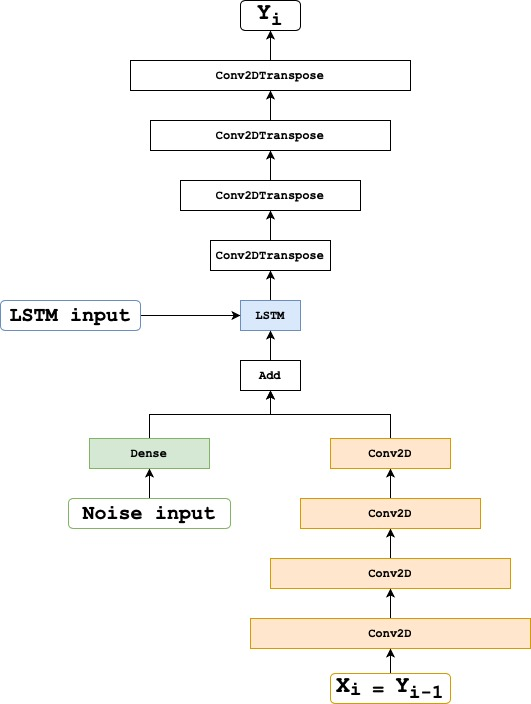
</div>

In [ ]:
def create_generator(
    input_shape = (None, params.LSTM_WINDOW, params.MEL_BINS), 
    lstm_units = params.LSTM_UNITS_GEN,
    noise_dim = params.GEN_NOISE_DIM):
    
    inputs = tf.keras.Input(shape=input_shape)
    noise_inputs = tf.keras.Input(batch_shape=(None, noise_dim))
    lstm_states_input = [
        tf.keras.Input(batch_shape=(None, lstm_units)),
        tf.keras.Input(batch_shape=(None, lstm_units))
    ]
    
    x = layers.Rescaling(scale=1/110, offset=40/110)(inputs)

    # downsample previous output
    x = tf.expand_dims(x, axis=-1)
    for filters in (16, 32, 64, 128, 256, 128):
        x = layers.Conv2D(filters, (3,3), strides=2, padding='same')(x)
        x = layers.ReLU()(x)
        x = layers.BatchNormalization()(x)
    x = layers.Reshape((-1, 4*4*128))(x)
    
    # add noise
    noise = layers.Dense(4*4*128, activation='relu')(noise_inputs)
    x = layers.Add()([x, noise])

    # LSTM
    x, *h = layers.LSTM(lstm_units, return_sequences=True, return_state=True, name="LSTM")(x, initial_state=lstm_states_input)
    x = layers.Dense(8*8*128)(x)
    x = layers.ReLU()(x)

    # deconv upsample
    x = layers.Reshape((-1, 8,8,128))(x)
    
    for filters in (256, 128, 64, 32, 16):
        x = layers.TimeDistributed(layers.Conv2DTranspose(filters, (3,3), strides=2, padding='same'))(x)
        x = layers.ReLU()(x)
    x = layers.Conv2D(1, (3,3), strides=1, padding='same', activation='sigmoid')(x)

    x = layers.Rescaling(scale=110., offset=-40.)(x)
    spec = layers.Reshape((-1, 256, 256))(x)

    outputs = (spec, h)
    return tf.keras.Model([inputs, noise_inputs, lstm_states_input], outputs)

create_generator().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 256,   0           []                               
                                256)]                                                             
                                                                                                  
 rescaling (Rescaling)          (None, None, 256, 2  0           ['input_1[0][0]']                
                                56)                                                               
                                                                                                  
 tf.expand_dims (TFOpLambda)    (None, None, 256, 2  0           ['rescaling[0][0]']              
                                56, 1)                                                        


## Discriminator

In [ ]:
d_constraint = tf.keras.constraints.MinMaxNorm(
    min_value=-params.WGAN_D_CONSTRAINT, max_value=params.WGAN_D_CONSTRAINT
)

def create_discriminator(
    input_shape = (None, params.LSTM_WINDOW, params.MEL_BINS),
    lstm_units = params.LSTM_UNITS_DISC):
    
    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Rescaling(scale=1/110, offset=40/110)(inputs)
    
    # downsample
    x = tf.expand_dims(x, axis=-1)
    for filters in (16, 32, 64, 128, 256, 128):
        x = layers.Conv2D(filters, (3,3), strides=2, padding='same', kernel_constraint=d_constraint)(x)
        x = layers.ReLU()(x)
        x = layers.Dropout(0.3)(x)
        x = layers.BatchNormalization()(x)

    x = layers.Reshape((-1, 4*4*128))(x)
    x = layers.LSTM(
        lstm_units, 
        return_sequences=True, 
        kernel_constraint=d_constraint, 
    )(x)
    x = layers.Dense(1, activation='linear', kernel_constraint=d_constraint)(x)

    return tf.keras.Model(inputs, x)

create_discriminator().summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, 256, 256)]  0         
                                                                 
 rescaling_2 (Rescaling)     (None, None, 256, 256)    0         
                                                                 
 tf.expand_dims_1 (TFOpLambd  (None, None, 256, 256, 1  0        
 a)                          )                                   
                                                                 
 conv2d_7 (Conv2D)           (None, None, 128, 128, 1  160       
                             6)                                  
                                                                 
 re_lu_12 (ReLU)             (None, None, 128, 128, 1  0         
                             6)                                  
                                                           

## GAN

In [ ]:
def define_gan(generator, discriminator):
    discriminator.trainable = False
    g_in = generator.input
    g_out, _= generator.output
    gan_out = discriminator(g_out)

    model = tf.keras.Model(g_in, gan_out)
    return model

In [ ]:
class GAN(tf.keras.Model):
    def __init__(self, generator, discriminator, **kwargs):
        super(GAN, self).__init__(**kwargs)
        self.generator = generator
        self.gan = define_gan(generator, discriminator)
        #self.gan.summary()
        self.loss_tracker = tf.keras.metrics.Mean(name="generator loss")
    
    def compile(self, optimizer=None, loss=None):
        super(GAN, self).compile()
        self.opt = optimizer
        self.loss = loss

    @property
    def metrics(self):
        return [self.loss_tracker]
    
    # trains generator
    def train_step(self, data):
        inputs, noises, states = data[0]
        with tf.GradientTape() as tape:
            preds = tf.zeros((0, inputs.shape[1], 1)) # shape: 0 (batch), sequence_len, 1 (prediction)
            for i in range(params.BATCH_SIZE):
                initial_state = [s[i:i+1] for s in states]
                noise = noises[i:i+1]
                pred = self.gan([inputs[i:i+1], noise, initial_state])           # predict sequence
                preds = tf.concat([preds, pred], 0)                              # add sequence to batch
            loss = self.loss(preds, tf.ones((preds.shape)))
        grads = tape.gradient(loss, self.gan.trainable_weights)
        self.opt.apply_gradients(zip(grads, self.gan.trainable_weights))

        self.loss_tracker.update_state(loss)
        return {
            "loss":self.loss_tracker.result()
        }

# Training

In [ ]:
def make_fake_data(generator, batch_size=1, seq_length=20):
    spec_shape = generator.output[0].shape[2:]

    out = tf.zeros((0, seq_length, *spec_shape))
    g_noises = tf.zeros((0, params.GEN_NOISE_DIM))
    initial_states = [tf.zeros((0, params.LSTM_UNITS_GEN)), tf.zeros((0, params.LSTM_UNITS_GEN))]
    
    for b in range(batch_size):
        gen_seq = tf.zeros((1, 0, *spec_shape))
        g_in_prev = tf.zeros((1, 1, *spec_shape))
        
        g_noise = tf.random.normal((1, params.GEN_NOISE_DIM))
        g_noises = tf.concat([g_noises, g_noise], 0)

        g_states_prev = [
            tf.zeros((1, params.LSTM_UNITS_GEN)),
            tf.zeros((1, params.LSTM_UNITS_GEN))
        ]
        initial_states = [tf.concat([initial_states[i], g_states_prev[i]], 0) for i in range(len(initial_states))]
        
        for s in range(seq_length):
            g_in_prev, g_states_prev = generator([g_in_prev, g_noise, g_states_prev])
            gen_seq = tf.concat((gen_seq, g_in_prev), 1)
        out = tf.concat((out, gen_seq), 0)

    return out, g_noises, initial_states

In [ ]:
def train(discriminator, gan, dataset, seq_schedule=((20, 10),)):
    batch_size = params.BATCH_SIZE

    for seq_length, epochs in seq_schedule:
        for epoch in range(epochs):
            print(f"Starting epoch {epoch+1}")
            print(seq_length)
            t_start = time.time()
            data = iter(dataset)

            d_loss = []
            g_loss = []
            n_batches = int(np.ceil(len(dataset) / params.N_CRITIC))
            for batch in range(n_batches):
                # train discriminator
                for _ in range(params.N_CRITIC):
                    try:
                        # get real batch
                        X_real = data.get_next()[:,:seq_length]
                        print(X_real.shape)
                        # generate batch
                        X_fake, _, _ = make_fake_data(gan.generator, batch_size=X_real.shape[0], seq_length=seq_length)
                        print(X_fake.shape)
                        # create labels (real: 1, fake: -1)
                        l_real = tf.ones((*X_real.shape[:2], 1))
                        l_fake = -tf.ones((*X_fake.shape[:2], 1))

                        # train
                        X = tf.concat([X_real, X_fake], 0)
                        l = tf.concat([l_real, l_fake], 0)
                        d_loss.append(discriminator.train_on_batch(X, y=l, reset_metrics=True))
                    
                    except tf.errors.OutOfRangeError: # if N_CRITIC batches are not available
                        break

                # generate [0] + 19 "inputs"
                g_inputs, g_noises, initial_states = make_fake_data(gan.generator, batch_size=batch_size, seq_length=seq_length-1)
                g_in_0 = tf.ones((batch_size, 1, *g_inputs.shape[2:]))
                g_inputs = tf.concat([g_in_0, g_inputs], 1) # add first input to sequence
                print(g_inputs.shape)
                
                # train generator with pre-generated inputs
                g_loss.append(gan.train_on_batch([g_inputs, g_noises, initial_states], reset_metrics=True))
                #print(f"Batch: {batch} ({time.time() - t_start:.1f}s)\n  d_loss: {np.mean([d_loss])}\n  g_loss: {np.mean([g_loss])}")

            # print metrics
            print(f"\nEpoch {epoch+1} end ({time.time() - t_start:.1f}s):")
            print(f"  Discriminator loss: {np.mean(d_loss)}")
            print(f"  Generator loss: {np.mean(g_loss)}")
            
            # generate example
            input = tf.ones((1, 1, params.LSTM_WINDOW, params.MEL_BINS)) # first input (all zeros)
            noise = tf.random.normal((1, params.GEN_NOISE_DIM))
            states = [
                tf.zeros((1, params.LSTM_UNITS_GEN)), 
                tf.zeros((1, params.LSTM_UNITS_GEN))
            ]
            out = np.zeros((0, params.MEL_BINS))
            n_spect = 5
            for i in range(n_spect):
                input, states = gan.generator([input, noise, states])
                out = np.concatenate((out, input.numpy()[0,0]))
            show_spectrogram(out, title=f"min dB:{np.min(out)}, max dB:{np.max(out)}", n_spect=n_spect)
            show_audio(out)

In [ ]:
def wasserstein_loss(pred, labels):
    return tf.math.reduce_mean(tf.math.multiply(pred, labels))

In [ ]:
discriminator = create_discriminator()
discriminator.compile(optimizer=tf.keras.optimizers.RMSprop(5e-5), loss=wasserstein_loss)

generator = create_generator()

gan = GAN(generator, discriminator)
gan.compile(optimizer=tf.keras.optimizers.RMSprop(1e-3), loss=wasserstein_loss)

In [ ]:
train(discriminator, gan, ds_spect_train, seq_schedule=((1, 1), (10, 1), (20, 1)))

Starting epoch 1
1
(8, 1, 256, 256)
(8, 1, 256, 256)
(8, 1, 256, 256)
(8, 1, 256, 256)
(8, 1, 256, 256)
(8, 1, 256, 256)
(8, 1, 256, 256)
(8, 1, 256, 256)
(8, 1, 256, 256)


AttributeError: ignored